In [2]:
version = 'v20250521'

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import copy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
import joblib
import numpy as np

# discretinized points
df = pd.read_parquet('./material/agg_pixel_change.pq')
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:3035")
print(df.shape)

# # samples # in the end, we didn't opt for sample vs. pixel comparison
# spl = pd.read_parquet(f'./material/srs_agg_{version}.pq')
# geometry = [Point(xy) for xy in zip(spl['lon_mean'], spl['lat_mean'])]
# spl = gpd.GeoDataFrame(spl, geometry=geometry, crs="EPSG:4032")
# spl = spl.to_crs('EPSG:3035')

sizes = [2.5, 10, 40, 200]

In [3]:
for isize in sizes:
    ttprint(isize, '-------------------------------')
    plg = gpd.read_file(f'./material/grid_all.{isize}km_agg.vlz.{version}.gpkg')
    df = gpd.sjoin(df, plg[['geometry']], how="inner", predicate="intersects")
    df = df.rename(columns={'index_right':f'id_{isize}'})

## read in the predicted point level data

In [15]:
agg = []
for isize in [50,100,200]:
    tgg = gpd.read_file(f'./material/grid_all.{isize}km_agg.calc.{version}.gpkg')
    tgg['size'] = isize
    agg.append(tgg)
    
agg_pnt = pd.concat(agg)


## get paired SNR

In [4]:
# organize data pairs
tcol = ['time', 'sample_mean','sample_std','sample_count', 'pred_std','pred_mean','ndvi'] # time series cols
scol = ['id', 'geometry', 'nuts0'] # static cols

ttprint('start organizing pairs')

ap = []
for isize in [50,100,200]:
    agg = gpd.read_file(f'./material/grid_all.{isize}km_agg.calc.{version}.gpkg')
    agp_df = pd.DataFrame(columns=scol + tcol)
    for iid in agg['id'].unique():
        temp = agg.loc[agg['id'] == iid].sort_values(by=['time'])  

        static_vals = temp.iloc[0][scol].tolist()

        ts_vals = [temp.iloc[[0, 1]][itcol].tolist() for itcol in tcol]
        agp_df.loc[len(agp_df)] = static_vals + ts_vals

        ts_vals = [temp.iloc[[1, 2]][itcol].tolist() for itcol in tcol]
        agp_df.loc[len(agp_df)] = static_vals + ts_vals

        ts_vals = [temp.iloc[[0, 2]][itcol].tolist() for itcol in tcol]
        agp_df.loc[len(agp_df)] = static_vals + ts_vals
        
    agp_df['change_obsv'] = agp_df['sample_mean'].str[1]-agp_df['sample_mean'].str[0]
    agp_df['change_pred'] = agp_df['pred_mean'].str[1]-agp_df['pred_mean'].str[0]
    agp_df['noise'] = np.sqrt(agp_df['pred_std'].str[1]**2+agp_df['pred_std'].str[0]**2)
    agp_df['signal'] = agp_df['change_pred'].abs()
    agp_df['SNR'] = agp_df['signal']/agp_df['noise']
    agp_df['size'] = isize
    
    agp_df = gpd.GeoDataFrame(agp_df, geometry=agp_df['geometry'], crs="EPSG:3035")
    agp_df['times'] = agp_df['time'].str[0].astype(str) + '-' + agp_df['time'].str[1].astype(str)
    agp_df['count1'] = agp_df['sample_count'].str[0]
    agp_df['count2'] = agp_df['sample_count'].str[1]
    agp_df[['id','nuts0','geometry','noise','signal','SNR','size','change_obsv', 'change_pred', 'times', 'count1','count2']].to_file(f'./material/grid.pair_all.{isize}km_agg.calc.{version}.gpkg')
    ap.append(agp_df)

ttprint('finish organizing')
agg_pair = pd.concat(ap)
print(agg_pair.shape)

agg_pair.to_parquet(f'./material/grid.pair_all.size_agg.calc.{version}.pq')


[16:46:18] start organizing pairs
[16:46:32] finish organizing
(1158, 19)


## get series SNR

In [6]:
# organize time series
tcol = ['time', 'sample_mean','sample_std','sample_count', 'pred_std','pred_mean','ndvi'] # time series cols
scol = ['id', 'geometry', 'nuts0'] # static cols

ttprint('start organizing series')
ags_df = pd.DataFrame(columns=scol + tcol + ['size'])
ass = []
for isize in [50,100,200]:
    agg = gpd.read_file(f'./material/grid_all.{isize}km_agg.calc.{version}.gpkg')
    for iid in agg['id'].unique():
        temp = agg.loc[agg['id'] == iid].sort_values(by=['time'])  

        static_vals = temp.iloc[0][scol].tolist()
        ts_vals = [temp[itcol].tolist() for itcol in tcol]

        ags_df.loc[len(ags_df)] = static_vals + ts_vals + [isize]
        
    ass.append(ags_df)
    
ttprint('finish organizing')
agg_srs = pd.concat(ass)


[16:51:29] start organizing series
[16:51:31] finish organizing


In [10]:
# obtain time series SNR
from sklearn.linear_model import HuberRegressor, TheilSenRegressor

plzc = [] # two consecutive soc changes
tsr = TheilSenRegressor(random_state=42)
slope_sample = [] 
slope_pred = [] 
intercept_sample = [] # linear intercept
score_sample = [] # R2 of predicted linear time series
intercept_pred = [] # linear intercept
score_pred = [] # R2 of predicted linear time series
std_slope_list = []

ttprint('start organizing')
for index, row in agg_srs.iterrows():
    soc_s = row['sample_mean']
    soc_p = row['pred_mean']
    if np.isnan(soc_s).any():
        plzc.append(np.nan)
        slope_sample.append(np.nan)
        intercept_sample.append(np.nan)
        score_sample.append(np.nan)
        slope_pred.append(np.nan)
        intercept_pred.append(np.nan)
        score_pred.append(np.nan)
        std_slope_list.append(np.nan)
        continue

    time = row['time']
    soc_std = row['pred_std']
        
    # fit linear slope
    X = np.array(time)-2009
    # for observations
    tsr.fit(X.reshape(-1, 1), np.array(soc_s))
    slope_sample.append(tsr.coef_[0])
    intercept_sample.append(tsr.intercept_)
    score_sample.append(tsr.score(X.reshape(-1, 1), np.array(soc_s)))
    # for prediction
    tsr.fit(X.reshape(-1, 1), np.array(soc_p))
    slope_pred.append(tsr.coef_[0])
    intercept_pred.append(tsr.intercept_)
    score_pred.append(tsr.score(X.reshape(-1, 1), np.array(soc_p)))
    
    # shape becomes (n_realizations, n_time_steps), e.g., (120, 3)
    n_realizations = 120
    rt = np.random.normal(loc=soc_p, scale=soc_std, size=(n_realizations, 3))
    slope_r = []

    for i in range(200):  # 50 Monte Carlo samples
        # Sample one realization (index) per time step
        # Choose a random index from 0 to 119 (assuming 120 realizations)
        sample_indices = np.random.randint(0, rt.shape[0], size=rt.shape[1])
        ss = np.array([rt[sample_indices[j], j] for j in range(rt.shape[1])])  # shape (n_time_steps,)

        tsr.fit(X.reshape(-1, 1), ss)
        slope_r.append(tsr.coef_[0])
        # score_r.append(tsr.score(X.reshape(-1, 1), ss))

    # Store statistics
    std_slope_list.append(np.std(slope_r))
    # m_slope_list.append(np.mean(slope_r))
    # std_score_list.append(np.std(score_r))
    # m_score_list.append(np.mean(score_r))
    
ttprint('finish organizing')
    
agg_srs[r'slope_sample'] = slope_sample
agg_srs[r'intercept_sample'] = intercept_sample
agg_srs[r'score_sample'] = score_sample
agg_srs[r'slope_pred'] = slope_pred
agg_srs[r'intercept_pred'] = intercept_pred
agg_srs[r'score_pred'] = score_pred
agg_srs[r'noise'] = std_slope_list
agg_srs['signal'] = agg_srs['slope_pred'].abs()
agg_srs['SNR'] = agg_srs['signal']/agg_srs['noise']

[16:52:51] start organizing
[16:57:41] finish organizing


In [13]:
agg_srs[['id', 'nuts0', 'time', 'sample_mean', 'sample_std','sample_count', 'pred_std', 'pred_mean', 'ndvi', 'size', 
         'slope_sample','intercept_sample', 'score_sample', 'slope_pred','intercept_pred','score_pred',
         'noise', 'signal', 'SNR']].to_parquet(f'./material/grid.srs_all.size_agg.calc.{version}.pq')
agg_srs = gpd.GeoDataFrame(agg_srs, geometry=agg_srs['geometry'], crs="EPSG:3035")
for isize in [50,100,200]:
    agg_srs.loc[agg_srs['size']==isize][['id','nuts0','geometry','noise','signal','SNR','size', 'slope_sample', 'slope_pred']].to_file(f'./material/grid.srs_all.{isize}km_agg.calc.{version}.gpkg')

### plot

In [23]:
agg_pnt['signal'] = agg_pnt['pred_mean']
agg_pnt['noise'] = agg_pnt['pred_std']
agg_pnt['SNR'] = agg_pnt['signal']/agg_pnt['noise']

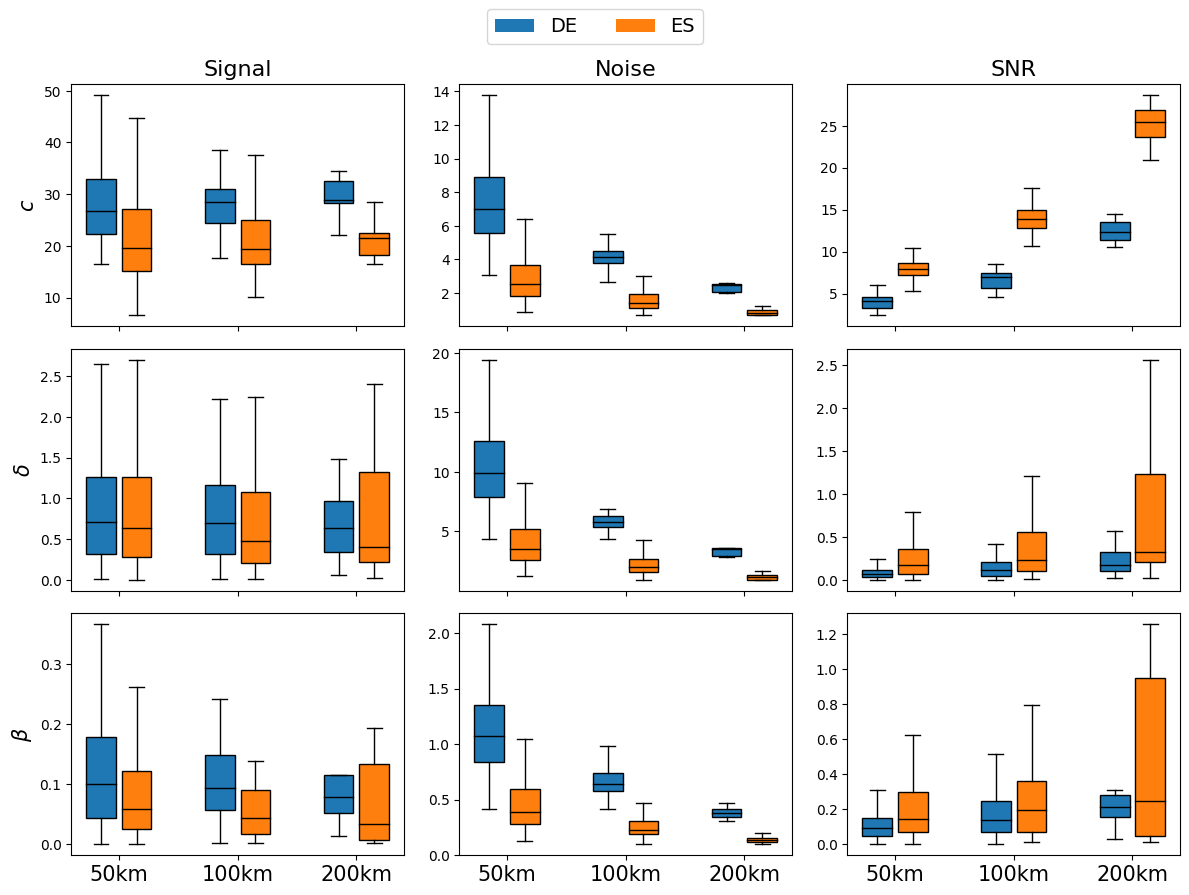

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Patch

# DataFrames: agg_pnt, agg_pair, agg_srs
dataframes = [agg_pnt, agg_pair, agg_srs]
df_labels = ['$c$', '$\delta$', r'$\beta$']
metrics = ['signal', 'noise', 'SNR']

# Unique sizes and regions
all_scales = sorted(set(agg_pnt['size']) | set(agg_pair['size']) | set(agg_srs['size']))
all_regions = sorted(set(agg_pnt['nuts0']) | set(agg_pair['nuts0']) | set(agg_srs['nuts0']))

# Assign colors
region_colors = {region: color for region, color in zip(all_regions, ['tab:blue', 'tab:orange'])}

# Create subplot grid
fig, axes = plt.subplots(3, 3, figsize=(12, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

offset = 0.6  # spacing between ES and DE
group_spacing = 2

for row_idx, (df, df_label) in enumerate(zip(dataframes, df_labels)):
    for col_idx, metric in enumerate(metrics):
        ax = axes[row_idx, col_idx]
        num_scales = len(all_scales)

        for i, region in enumerate(all_regions):
            data_per_scale = []
            positions = []

            for j, scale in enumerate(all_scales):
                subset = df[(df['size'] == scale) & (df['nuts0'] == region)][metric].dropna()
                if len(subset) > 0:
                    data_per_scale.append(subset.values)
                    pos = j * group_spacing + i * offset
                    positions.append(pos)

            if data_per_scale:  # Only plot if we have valid data
                bp = ax.boxplot(
                    data_per_scale,
                    positions=positions,
                    widths=0.5,
                    patch_artist=True,
                    showfliers=False,
                    boxprops=dict(facecolor=region_colors[region], color='black'),
                    medianprops=dict(color='black'),
                    whiskerprops=dict(color='black'),
                    capprops=dict(color='black')
                )

            # positions = np.arange(num_scales) * group_spacing + i * offset
            # bp = ax.boxplot(
            #     data_per_scale,
            #     positions=positions,
            #     widths=0.5,
            #     patch_artist=True,
            #     showfliers=False,
            #     boxprops=dict(facecolor=region_colors[region], color='black'),
            #     medianprops=dict(color='black'),
            #     whiskerprops=dict(color='black'),
            #     capprops=dict(color='black')
            # )

        # Set titles and labels
        if row_idx == 0:
            if metric == 'signal':
                metric = 'Signal'
            if metric == 'noise':
                metric = 'Noise'
            ax.set_title(metric, fontsize=16)
        if col_idx == 0:
            ax.set_ylabel(df_label, fontsize=15)

        # Set x-ticks centered between pairs
        tick_positions = np.arange(num_scales) * group_spacing + offset / 2
        ax.set_xticks(tick_positions)
        if row_idx == 2:
            ax.set_xticklabels([f'{s}km' for s in all_scales], fontsize=15)
        else:
            ax.set_xticklabels([])

# Add color legend
legend_elements = [Patch(facecolor=region_colors[r], label=r) for r in all_regions]
fig.legend(handles=legend_elements, loc='upper center', ncol=len(all_regions), fontsize=14)

# Tidy layout with top space for legend
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f'./figure/plot_agg_compare.pdf', bbox_inches='tight')
plt.show()
